# Part 3B: Data Modeling with Lyrics (NLP)
This part of the project focuses on building multi-classification models to predict music genre using song lyric data alone (Natural Language Processing). 

Each model is created with a pipeline to combine CountVectorizer or TFID in combination with a classifier model (e.g. Random Forest Classifier). 

Data relies on the cleaned lyrics created in the Data Pre-Processing stage (Part 2).

In [67]:
import pandas as pd
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

#sci-kit learn classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

#text/NLP 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

from sklearn.metrics import (confusion_matrix, plot_confusion_matrix,
    accuracy_score, plot_roc_curve, roc_auc_score, recall_score,
    precision_score, roc_curve, auc)
from sklearn.metrics import ConfusionMatrixDisplay


#for oversampling 
from imblearn.over_sampling import RandomOverSampler

In [13]:
df = pd.read_csv('../data/data_lyrics.csv')

In [14]:
df.head(3)

,id,track,artist,lyrics,genre,cleaned_lyrics,title_length,lines,sections,verse_count,...,lyrics_contain_title,emot_positive,emot_negative,emot_anger,emot_trust,emot_disgust,emot_fear,emot_joy,emot_surprise,emot_anticp
0,6qc34bnVOyqGDPni8H5W0U,Amazed,Lonestar,[Verse 1]\nEvery time our eyes meet\nThis feel...,country,Every time our eyes meet This feeling inside ...,6,55,6,2,...,True,0.263158,0.105263,0.052632,0.026316,0.052632,0.052632,0.157895,0.052632,0.0
1,3EUl8M6SzxZl03NPkB8mUd,Neon Moon,Brooks & Dunn,[Verse 1]\nWhen the sun goes down on my side o...,country,When the sun goes down on my side of town Tha...,9,62,9,5,...,True,0.070707,0.151515,0.131313,0.060606,0.060606,0.171717,0.070707,0.060606,0.0
2,7lUE02KHkZM44BZgjCaWRO,Meet In the Middle,Diamond Rio,[Verse 1]\nIt was seven hundred fence posts fr...,country,It was seven hundred fence posts from your pl...,18,44,6,2,...,True,0.150000,0.100000,0.016667,0.100000,0.016667,0.000000,0.133333,0.016667,0.0


In [7]:
X = df['cleaned_lyrics']
y = df['genre']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [19]:
y_train.value_counts(normalize=True)

rock         0.299270
dance_pop    0.286496
hip_hop      0.245985
country      0.168248
Name: genre, dtype: float64

In [83]:
def get_metrics(model_name, model, X, y, over=False):
    #create labels and empty df
    labels = ['country','dance_pop','hip_hop','rock']
    #set up model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
    #if oversampling is False, fit on regular X_train, y_train splot
    if over==False:
        model.fit(X_train,y_train)
        preds = model.predict(X_test)
        train_score = model.score(X_train,y_train)
    #if oversampling is True, use RandomOverSample to balance classes for training data
    elif over==True:
        oversample = RandomOverSampler(sampling_strategy='auto', random_state=42)
        X_over, y_over = oversample.fit_resample(pd.DataFrame(X_train), y_train)
        X_over = X_over.squeeze()
        model.fit(X_over,y_over)
        preds = model.predict(X_test)
        train_score = model.score(X_over, y_over)
    #store results
    data = confusion_matrix(y_test, preds)
    results = {labels[i] : data[i][i]/sum(data[i]) for i in range(0, len(data))}
    result_df = pd.DataFrame(results, index=[0])
    result_df['model'] = model_name
    result_df['oversampling'] = over
    result_df['train_accuracy'] = train_score
    result_df['accuracy'] = model.score(X_test,y_test)
    return result_df[['model','oversampling','train_accuracy','accuracy'] + labels]

## Random Forest Classifier

In [20]:
pipe_cv_rfc = Pipeline([
    ('cv', CountVectorizer()),
    ('rfc', RandomForestClassifier(random_state=42))
])

#fit
pipe_cv_rfc.fit(X_train,y_train)
pipe_cv_rfc.score(X_train, y_train), pipe_cv_rfc.score(X_test,y_test)

(0.9978102189781022, 0.6496350364963503)

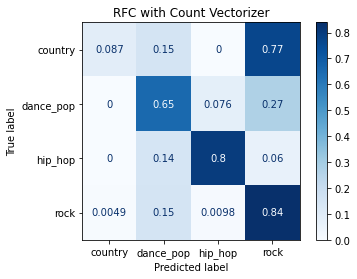

In [21]:
ConfusionMatrixDisplay.from_estimator(pipe_cv_rfc, X_test, y_test, cmap="Blues", normalize='true')
plt.title("RFC with Count Vectorizer");

In [22]:
pipe_tfv_rfc = Pipeline([
    ('tfv',TfidfVectorizer()),
    ('rfc', RandomForestClassifier())
])

#fit
pipe_tfv_rfc.fit(X_train,y_train)
pipe_tfv_rfc.score(X_train, y_train), pipe_tfv_rfc.score(X_test,y_test)

(0.9978102189781022, 0.6437956204379562)

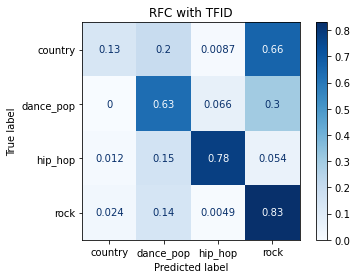

In [23]:
ConfusionMatrixDisplay.from_estimator(pipe_tfv_rfc, X_test, y_test, cmap="Blues", normalize='true')
plt.title("RFC with TFID");

## SVM

In [163]:
pipe_cv_svm = Pipeline([
    ('cv',CountVectorizer()),
    ('svm', svm.SVC(C=1.0, kernel='linear', random_state=42))]
)

pipe_cv_svm.fit(X_train,y_train)
pipe_cv_svm.score(X_train,y_train), pipe_cv_svm.score(X_test,y_test)

(0.9962160302717579, 0.6491228070175439)

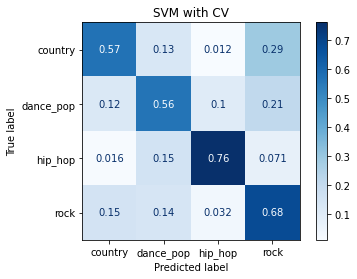

In [164]:
ConfusionMatrixDisplay.from_estimator(pipe_cv_svm, X_test, y_test, cmap="Blues", normalize='true')
plt.title("SVM with CV");

In [65]:
pipe_tfv_svm = Pipeline([
    ('cv',TfidfVectorizer()),
    ('svm', svm.SVC(C=1.0, kernel='linear', random_state=42))]
)

pipe_tfv_svm.fit(X_train,y_train)
pipe_tfv_svm.score(X_train,y_train), pipe_tfv_svm.score(X_test,y_test)

(0.8992700729927007, 0.6671532846715329)

## Decision Tree

In [24]:
pipe_cv_dtc = Pipeline([
    ('cv',CountVectorizer()),
    ('dtc', DecisionTreeClassifier(random_state=42))]
)

pipe_cv_dtc.fit(X_train,y_train)
pipe_cv_dtc.score(X_train,y_train), pipe_cv_dtc.score(X_test,y_test)

(0.9978102189781022, 0.5489051094890511)

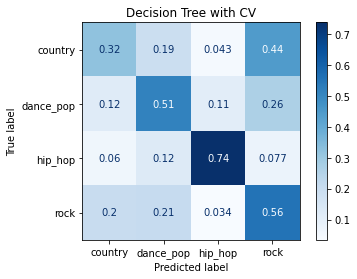

In [25]:
ConfusionMatrixDisplay.from_estimator(pipe_cv_dtc, X_test, y_test, cmap="Blues", normalize='true')
plt.title("Decision Tree with CV");

In [26]:
pipe_tfid_dtc = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('dtc', DecisionTreeClassifier(random_state=42))]
)

pipe_tfid_dtc.fit(X_train,y_train)
pipe_tfid_dtc.score(X_train,y_train), pipe_tfid_dtc.score(X_test,y_test)

(0.9978102189781022, 0.5328467153284672)

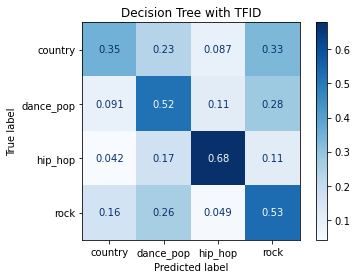

In [27]:
ConfusionMatrixDisplay.from_estimator(pipe_tfid_dtc, X_test, y_test, cmap="Blues", normalize='true')
plt.title("Decision Tree with TFID");

# Classifiers with Oversampling

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42, stratify=y)
y_train.value_counts()

rock         820
dance_pop    785
hip_hop      674
country      461
Name: genre, dtype: int64

In [41]:
oversample = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_over, y_over = oversample.fit_resample(pd.DataFrame(X_train), y_train)
y_over.value_counts()

rock         820
country      820
hip_hop      820
dance_pop    820
Name: genre, dtype: int64

In [52]:
pipe_cv_rfc_os = Pipeline([
    ('cv', CountVectorizer()),
    ('rfc', RandomForestClassifier(random_state=42))
])

#fit
X_over = X_over.squeeze()
pipe_cv_rfc_os.fit(X_over,y_over)
pipe_cv_rfc_os.score(X_over, y_over), pipe_cv_rfc_os.score(X_test,y_test)

(0.9981707317073171, 0.6788321167883211)

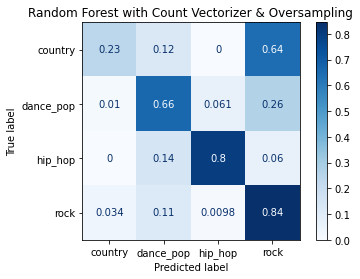

In [91]:
ConfusionMatrixDisplay.from_estimator(pipe_cv_rfc_os, X_test, y_test, cmap="Blues", normalize='true')
plt.title("Random Forest with Count Vectorizer & Oversampling");
plt.savefig('../plots/Lyrics_RFC_CV_OS.jpeg')

In [87]:
pipe_tfv_svm_os = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('svm', svm.SVC(C=1.0, kernel='linear', random_state=42))]
)

pipe_tfv_svm_os.fit(X_over,y_over)
pipe_tfv_svm_os.score(X_over,y_over), pipe_tfv_svm_os.score(X_test,y_test)

(0.9179878048780488, 0.6686131386861314)

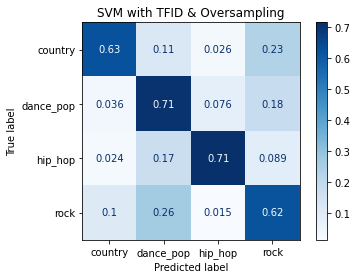

In [90]:
ConfusionMatrixDisplay.from_estimator(pipe_tfv_svm_os, X_test, y_test, cmap="Blues", normalize='true')
plt.title("SVM with TFID & Oversampling");
plt.savefig('../plots/Lyrics_SVM_TFID_OS.jpeg')

In [76]:
get_metrics("Random Forest with CountVect & Oversampling", pipe_cv_rfc, X, y, True)

,model,train_accuracy,accuracy,country,dance_pop,hip_hop,rock
0,Random Forest with CountVect & Oversampling,0.998171,0.678832,0.234783,0.664975,0.797619,0.843902


In [84]:
results = pd.concat([get_metrics("Random Forest with CountVectorizer", pipe_cv_rfc, X, y),
           get_metrics("Random Forest with CountVectorizer", pipe_cv_rfc, X, y, True),
           get_metrics("Random Forest with TFID", pipe_tfv_rfc, X, y),
           get_metrics("Random Forest with TFID", pipe_tfv_rfc, X, y, True),
           get_metrics("Decision Tree with CountVectorizer", pipe_cv_dtc, X, y),
           get_metrics("SVM with CountVectorizer", pipe_cv_svm, X, y),
           get_metrics("SVM with CountVectorizer", pipe_cv_svm, X, y, True),
           get_metrics("SVM with TFID", pipe_tfv_svm, X, y),
           get_metrics("SVM with TFID", pipe_tfv_svm, X, y, True)
          ]
         )
results

,model,oversampling,train_accuracy,accuracy,country,dance_pop,hip_hop,rock
0,Random Forest with CountVectorizer,False,0.997810,0.649635,0.086957,0.654822,0.797619,0.839024
0,Random Forest with CountVectorizer,True,0.998171,0.678832,0.234783,0.664975,0.797619,0.843902
0,Random Forest with TFID,False,0.997810,0.645255,0.130435,0.624365,0.797619,0.829268
0,Random Forest with TFID,True,0.998171,0.651095,0.278261,0.614213,0.803571,0.770732
0,Decision Tree with CountVectorizer,False,0.997810,0.548905,0.321739,0.512690,0.738095,0.556098
0,SVM with CountVectorizer,False,0.997810,0.627737,0.539130,0.578680,0.702381,0.663415
0,SVM with CountVectorizer,True,0.998171,0.627737,0.539130,0.578680,0.702381,0.663415
0,SVM with TFID,False,0.899270,0.667153,0.521739,0.700508,0.702381,0.687805
0,SVM with TFID,True,0.917988,0.668613,0.626087,0.705584,0.714286,0.619512


In [85]:
results.to_csv('../data/model_results_lyrics.csv')